In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout

In [7]:
df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)

C:\Users\17569\AppData\Local\Temp\ipykernel_22312\185645508.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)


In [8]:
print(df.iloc[1:10,:])


   0                                                  1  2
1  0  Hope (born 2010) is a bottlenose dolphin who i...  1
2  1  The Invasion of Umuahia (December 20-December ...  0
3  2  Morgan Adokwei Brown is a lawyer and human rig...  1
4  3  Martine Warmann (formerly Martine George; born...  1
5  4  The Last Face is a 2016 American drama film wr...  1
6  5  Placental mammals (infraclass Placentalia ) ar...  0
7  6  The People's Secretariat of Ukraine was the hi...  1
8  7  Slavic paganism or Slavic religion describes t...  1
9  8  Lieutenant Colonel John Thomas Eustace (March ...  1


In [9]:
df= df[0:200000]

In [ ]:


label_counts = df.iloc[:,2].value_counts()


print("num of 0:", label_counts.get(0, 0))
print("num of 1:", label_counts.get(1, 0))

In [46]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


max_words = 10000 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data.iloc[:, 1]) 

X_train = tokenizer.texts_to_sequences(train_data.iloc[:, 1])
X_test = tokenizer.texts_to_sequences(test_data.iloc[:, 1])

In [47]:
max_sequence_length = 100
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data.iloc[:, 2]) 
y_test = label_encoder.transform(test_data.iloc[:, 2])

Epoch 1/10
4000/4000 [==============================] - 148s 37ms/step - loss: 0.3482 - accuracy: 0.8469 - val_loss: 0.2152 - val_accuracy: 0.9250
Epoch 2/10
4000/4000 [==============================] - 151s 38ms/step - loss: 0.1905 - accuracy: 0.9341 - val_loss: 0.1862 - val_accuracy: 0.9311
Epoch 3/10
4000/4000 [==============================] - 154s 39ms/step - loss: 0.1621 - accuracy: 0.9431 - val_loss: 0.1806 - val_accuracy: 0.9305
Epoch 4/10
4000/4000 [==============================] - 151s 38ms/step - loss: 0.1448 - accuracy: 0.9485 - val_loss: 0.1760 - val_accuracy: 0.9326
Epoch 5/10
4000/4000 [==============================] - 163s 41ms/step - loss: 0.1329 - accuracy: 0.9527 - val_loss: 0.1725 - val_accuracy: 0.9316
Epoch 6/10
4000/4000 [==============================] - 158s 40ms/step - loss: 0.1243 - accuracy: 0.9551 - val_loss: 0.1798 - val_accuracy: 0.9322
Epoch 7/10
4000/4000 [==============================] - 150s 38ms/step - loss: 0.1189 - accuracy: 0.9572 - val_loss: 0

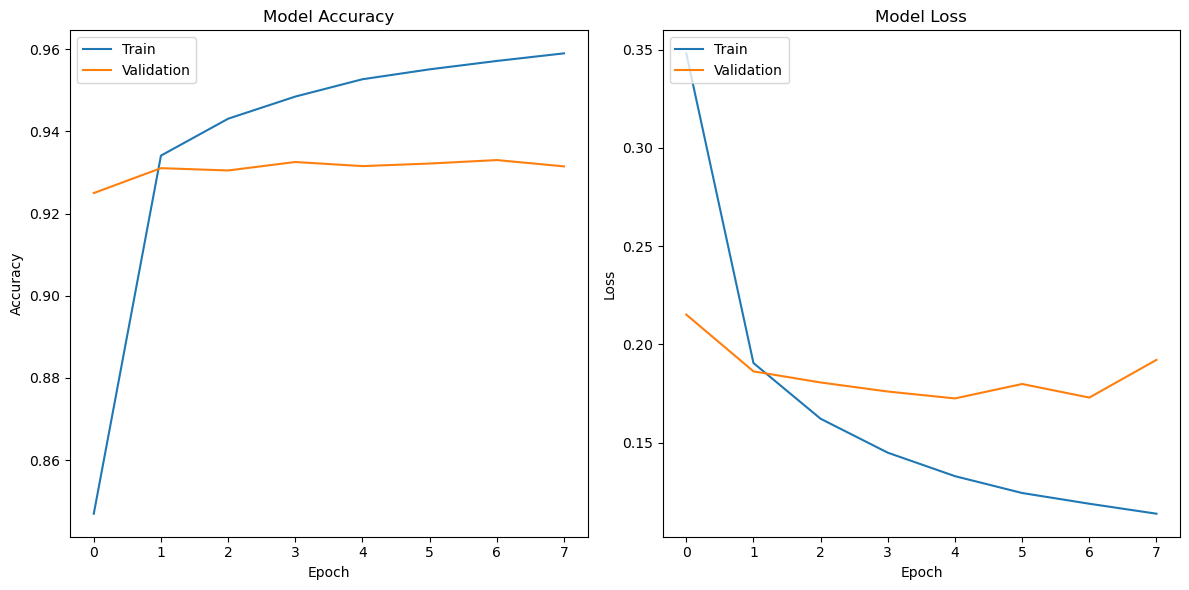

In [48]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import time
import matplotlib.pyplot as plt




embedding_dim = 50
hidden_units = 32

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=hidden_units))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
custom_optimizer = Adam(learning_rate=0.00006)

model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()


history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


end_time = time.time()


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [49]:
model.save('lstm_model.h5')

In [16]:
test_df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)[200001:]
print(test_df.shape)

(100000, 3)


C:\Users\17569\AppData\Local\Temp\ipykernel_10308\1910811553.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)[200001:]


In [26]:
print(test_df.iloc[1,1:])

1    Arcturus is a village in the province of Masho...
2                                                    0
Name: 200002, dtype: object


In [28]:
sampled_df = test_df.sample(n=400).iloc[:,1:]

sampled_df.to_csv('final_test_set.csv', index=False)

print("Sampled DataFrame Shape:", sampled_df.shape)

Sampled DataFrame Shape: (400, 2)


In [63]:
from keras.models import load_model

loaded_model = load_model('lstm_model.h5')

final_test_data = pd.read_csv('../dataset/testing_set/final_test_set.csv')
final_customize_test_data = pd.read_csv('../customize_test/combined_text_data.csv')

X_test  = pad_sequences(tokenizer.texts_to_sequences(final_test_data.iloc[:,0])  , maxlen=max_sequence_length)


y_test = label_encoder.transform(final_test_data.iloc[:,1].astype(str))

X_test_customize  = pad_sequences(tokenizer.texts_to_sequences(final_customize_test_data.iloc[:,0])  , maxlen=max_sequence_length)

y_test_customize = label_encoder.transform(final_customize_test_data.iloc[:,1].astype(str))


loss, accuracy = model.evaluate(X_test, y_test)
loss1, accuracy1 = model.evaluate(X_test_customize, y_test_customize)

2/2 [==============================] - 0s 10ms/step - loss: 0.4066 - accuracy: 0.8261


In [66]:
from sklearn.metrics import confusion_matrix, classification_report


y_pred = loaded_model.predict(X_test_customize)


y_pred_classes = (y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test_customize, y_pred_classes)


print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test_customize, y_pred_classes))


incorrect_samples = [i for i in range(len(y_test_customize)) if y_test_customize[i] != y_pred_classes[i]]
print(len(incorrect_samples))

for i in range( len(incorrect_samples)):
    index = incorrect_samples[i]
    print(f"real: {y_test_customize[index]}, predict: {y_pred_classes[index]}, prob: {y_pred[index]}")
    print(f"content: {final_customize_test_data.iloc[index, 0]}\n")


2/2 [==============================] - 0s 10ms/step
Confusion Matrix:
[[20  1]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        21
           1       0.95      0.72      0.82        25

    accuracy                           0.83        46
   macro avg       0.84      0.84      0.83        46
weighted avg       0.85      0.83      0.83        46

8
real: 1, predict: [0], prob: [0.0048727]
content: As we stroll through nature, feeling the gentle breeze on our faces and the soft earth beneath our feet. Trees shimmer with green hues in the sunlight, and small flowers dance in the grass. Birds sing cheerful tunes perched on branches, and fluffy clouds drift across the sky. All of this brings joy to the heart, as if embracing the arms of nature. Let's cherish the beauty around us and embrace the warmth of life.
Take a moment to appreciate the simple wonders – the rustle of leaves, the warmth of sunlig

In [58]:
y_pred1 = loaded_model.predict(X_test)


y_pred_classes1 = (y_pred1 > 0.5).astype(int)


conf_matrix1 = confusion_matrix(y_test, y_pred_classes1)


print("Confusion Matrix:")
print(conf_matrix1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes1))

13/13 [==============================] - 0s 16ms/step
Confusion Matrix:
[[184   9]
 [ 15 192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       193
           1       0.96      0.93      0.94       207

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400
